In [ ]:
import numpy as np
import pandas as pd
from time import time
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import fbeta_score,accuracy_score,make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from IPython.display import display
import visuals as vs

%matplotlib inline

data=pd.read_csv("/content/census.csv")
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [ ]:
n_records=data.shape[0]
n_greater_50k=data[data.income == '>50K'].shape[0]
n_at_most_50k=data[data.income == '<50K'].shape[0]
greater_percent=n_greater_50k * 100.0 / n_records

print("Total no of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making less than $50,000: {}".format(n_at_most_50k))
print("Percentage of Individuals making more than $50,000: {:.2f}%".format(greater_percent))


Total no of records: 45222
Individuals making more than $50,000: 11208
Individuals making less than $50,000: 0
Percentage of Individuals making more than $50,000: 24.78%


In [ ]:
data.dtypes

age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

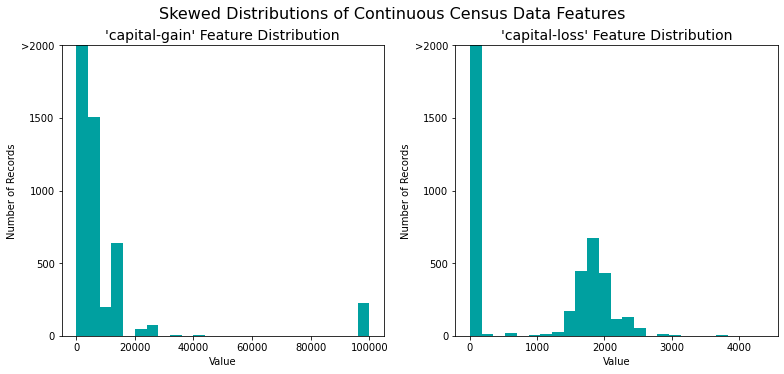

In [ ]:
income_raw=data['income']
features_raw=data.drop('income',axis=1)

vs.distribution(features_raw)

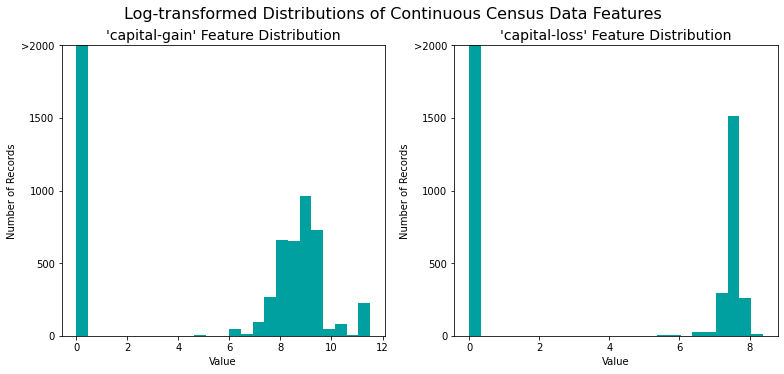

In [ ]:
skewed=['capital-gain','capital-loss']
features_log_transformed=pd.DataFrame(data=features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x+1))
vs.distribution(features_log_transformed,transformed=True)

In [ ]:
scaler=MinMaxScaler()
numerical=[
           'age','education-num','capital-gain','capital-loss','hours-per-week'
]

features_log_minmax_transform=pd.DataFrame(data=features_log_transformed)
features_log_minmax_transform[numerical]=scaler.fit_transform(features_log_transformed[numerical])
display(features_log_minmax_transform.head())

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


In [ ]:
features_final=pd.get_dummies(features_raw)

income=income_raw.apply(lambda x: int(x=='>50K'))

encoded=list(features_final.columns)
print("{} total features after one-hot encoding".format(len(encoded)))

103 total features after one-hot encoding


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(features_final,income,test_size=0.2,random_state=0)
print("Training set has {} samples".format(X_train.shape[0]))
print("Testing set has {} samples".format(X_test.shape[0]))

Training set has 36177 samples
Testing set has 9045 samples


In [ ]:
 true_positives=sum(y_train.append(y_test))
 true_negatives=0
 false_positives=y_train.append(y_test).value_counts()[0]
 false_negatives=0

 accuracy=true_positives / (true_positives+false_positives)
 precision=true_positives / (true_positives+false_positives)
 recall=true_positives / (true_positives+false_negatives)

 beta=0.5
 fscore=(1+beta**2)*(precision*recall)/((beta**2 * precision)+recall)

 print("Naive Predictor: [Accuracy score: {:.4f},F-score:{:.4f}]".format(accuracy,fscore))

Naive Predictor: [Accuracy score: 0.2478,F-score:0.2917]


In [ ]:
def train_predict(learner,sample_size,X_train,y_train,X_test,y_test):
  results={}
  start=time()
  learner=learner.fit(X_train[:sample_size],y_train[:sample_size])
  end=time()
  results['train_time']=end-start
  start=time()
  predictions_test=learner.predict(X_test)
  predictions_train=learner.predict(X_train[:300])
  end=time()
  results['pred_time']=end-start
  results['acc_train']=accuracy_score(y_train[:300],
                                      predictions_train[:300])
  results['acc_test']=accuracy_score(y_test,predictions_test)
  results['f_train']=fbeta_score(y_train[:300],predictions_train[:300],beta=0.5)
  results['f_test']=fbeta_score(y_test,predictions_test,beta=0.5)
  print("{} trained on {} samples.".format(learner .__class__.__name__,sample_size))
  return results
  

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression trained on 36177 samples.
LinearSVC trained on 361 samples.
LinearSVC trained on 3617 samples.
LinearSVC trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


/content/visuals.py:127: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


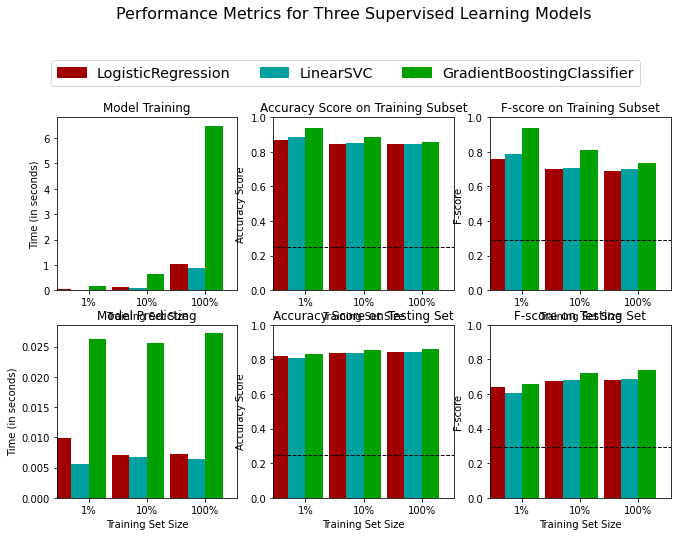

In [ ]:
clf_A=LogisticRegression(random_state=42)
clf_B=LinearSVC(random_state=42)
clf_C=GradientBoostingClassifier(random_state=42)

samples_100=len(y_train)
samples_10=int(samples_100/10)
samples_1=int(samples_100/100)

results={}
for clf in [clf_A,clf_B,clf_C]:
  clf_name=clf .__class__.__name__
  results[clf_name]={}
  for i,samples in enumerate([samples_1,samples_10,samples_100]):
    results[clf_name][i] = train_predict(clf,samples,X_train,y_train,X_test,y_test)
vs.evaluate(results,accuracy,fscore)

In [ ]:
clf=GradientBoostingClassifier(random_state=42)

parameters=[{'learning_rate': [0.05,0.1,0.15]},{'n_estimators':[250,500,750]}]
scorer=make_scorer(fbeta_score,beta=0.5)
grid_obj=GridSearchCV(clf,parameters,scoring=scorer,n_jobs=-1)
grid_fit=grid_obj.fit(X_train,y_train)
best_clf=grid_fit.best_estimator_

predictions=(clf.fit(X_train,y_train)).predict(X_test)
best_predictions=best_clf.predict(X_test)

print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test,predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test,predictions,beta=0.5)))
print("\nOptimized Model\n------")
print("Final Accuracy score on testin data: {:.4f}".format(fbeta_score(y_test,best_predictions,beta=0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final Accuracy score on testin data: 0.7545


In [ ]:
best_clf

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
data_numeric=features_log_minmax_transform.copy().select_dtypes(exclude=object)
data_numeric['income']=income
explore_numeric=data_numeric.groupby(by='income',as_index=False).describe()

In [ ]:
for feature in explore_numeric.columns.levels[0][:-1]:
  result=(explore_numeric[feature].iloc[[1]]['mean'][1] - explore_numeric[feature].iloc[[0]]['mean'][0]) / explore_numeric[feature].iloc[[1]]['std'][1]
  print(feature + ": "+ str(result))

age: 0.701768642435527
education-num: 0.8311604128912686
capital-gain: 0.42874856733128125
capital-loss: 0.22836396040303453
hours-per-week: 0.5851642573495133


In [ ]:
data_categorical=features_log_minmax_transform.copy().select_dtypes(include=object)
data_categorical['income']=income

In [ ]:
for feature in data_categorical.columns:
  if feature=='income':
    pass
  else:
    print(feature+": "+ str(data_categorical.groupby(by=feature).income.mean().std()))

workclass: 0.14316478860404366
education_level: 0.2491655034807551
marital-status: 0.17817581650752495
occupation: 0.14314138408838076
relationship: 0.2168656159383237
race: 0.0811921470550573
sex: 0.14064455183490965
native-country: 0.13563662545202018


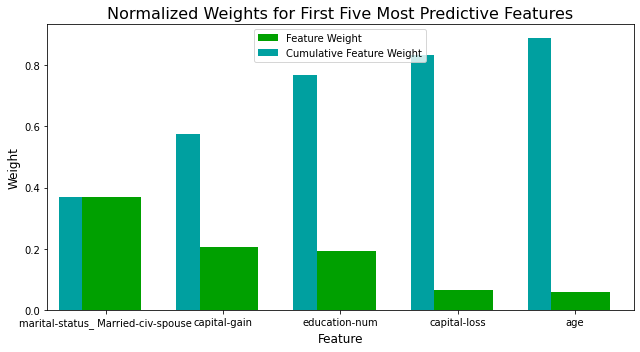

In [ ]:
importances= best_clf.feature_importances_
vs.feature_plot(importances,X_train,y_train)

In [ ]:
X_train_reduced=X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced=X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

clf=(clone(best_clf)).fit(X_train_reduced,y_train)

reduced_predictions=clf.predict(X_test_reduced)

print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test,best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test,best_predictions,beta=0.5)))
print("\nFinal model trained on reduced data\n-------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test,reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test,reduced_predictions,beta=0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8718
F-score on testing data: 0.7545

Final model trained on reduced data
-------
Accuracy on testing data: 0.8589
F-score on testing data: 0.7257
